In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pandas as pd
import os
import cv2

import zipfile
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [155]:
# Unzipping the data

with zipfile.ZipFile('archive (5).zip', 'r') as zip_ref:
    zip_ref.extractall()

### Reading the pictures from the directories

In [156]:
def preprocesing_image(image):
    # Gray scaling
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalizing
    normalized_image = gray_image / 255.0
    # Adding extra axis to make it compatible to deep learning models like CNN
    normalized_img = np.expand_dims(normalized_image, axis=-1)
    return normalized_img

In [157]:
data_folder = 'brain_tumor_dataset'

# Ensure the path is valid
if os.path.exists(data_folder):
    inner_folders = ['yes', 'no']
    image_data = []

    # Loop through each inner folder
    for folder in inner_folders:
        # Get the inner folder path
        folder_path = os.path.join(data_folder, folder)

        # Get the list of files in the folder
        files = os.listdir(folder_path)

        # Create touples with image and it's label
        #labeled_images = [(os.path.join(file,), folder) for file in files]
        labeled_images = []
        for image_path in files:
            image_inner_path = os.path.join(folder, image_path)
            full_image_path = os.path.join(data_folder, image_inner_path)
            image = cv2.imread(full_image_path)
            converted_image = preprocesing_image(image)
            labeled_images.append((converted_image, folder))

         # Adding the labeled images to the main list 
        image_data.extend(labeled_images)

        print(f"Folder '{folder}' contains {len(labeled_images)} images")

Folder 'yes' contains 155 images
Folder 'no' contains 98 images


In [158]:
len(image_data)

253

In [159]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
98


### Data Augmentation

In [160]:
# Aumentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

augmented_dir = 'brain_tumor_dataset/augmented'
os.makedirs(augmented_dir, exist_ok=True)

i = 0
for file in image_data:
    image, label = file[0], file[1]
    if label == 'no' and i <= 50:
        img_array = np.array(image)
        img_array = img_array.reshape((1,) + img_array.shape)
        
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir,
                                  save_prefix='aug', save_format='png'):
            break
        i += 1

In [161]:
len(image_data)

253

In [162]:
# Adding all augmented pictures to the data set

files = os.listdir(augmented_dir)

labeled_images = []
# Create touples with image and it's label
for image_path in files:
    full_image_path = os.path.join(augmented_dir, image_path)
    image = cv2.imread(full_image_path)
    converted_image = preprocesing_image(image)
    labeled_images.append((converted_image, 'no'))
    
image_data.extend(labeled_images)

# Maikng sure it worked
len(image_data)

303

In [163]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
148


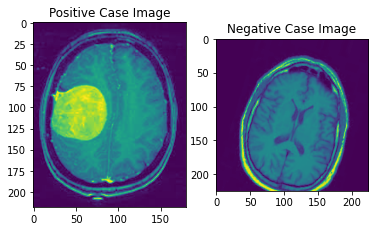

In [164]:
positive_image = image_data[0][0]
negative_image = image_data[253][0]

fix, axs = plt.subplots(1,2)
axs[0].imshow(positive_image)
axs[0].set_title('Positive Case Image')

axs[1].imshow(negative_image)
axs[1].set_title('Negative Case Image')

plt.show()

### Train-Val-Test split

In [165]:
image_data_shuffled = random.shuffle(image_data)

In [166]:
train_size = 0.7
validation_size = 0.15
test_size = 0.15

train_set, test_set = train_test_split(image_data, test_size=1 - train_size, random_state=42)
validation_set, test_set = train_test_split(test_set, test_size=test_size/(test_size + validation_size), random_state=42)

print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 212
Validation set size: 45
Test set size: 46


In [167]:
def count_picture_in_set(data_set: list, data_set_name: str):
    """
    counting the number of the pictures of each class in the data set
    """
    yes_pictures = [picture for picture in data_set if picture[1] == 'yes']
    no_pictures = [picture for picture in data_set if picture[1] == 'no']

    print(f"Number of positive cases in {data_set_name} is: {len(yes_pictures)}")
    print(f"Number of negative cases in {data_set_name} is: {len(no_pictures)}")

In [168]:
count_picture_in_set(train_set, 'train_set')
print("\n")
count_picture_in_set(validation_set, 'validation_set')
print("\n")
count_picture_in_set(test_set, 'test_set')

Number of positive cases in train_set is: 113
Number of negative cases in train_set is: 99


Number of positive cases in validation_set is: 23
Number of negative cases in validation_set is: 22


Number of positive cases in test_set is: 19
Number of negative cases in test_set is: 27


In [169]:
X_train = [picture[0] for picture in train_set]
y_train = [picture[1] for picture in train_set]

X_val = [picture[0] for picture in validation_set]
y_val = [picture[1] for picture in validation_set]

X_test = [picture[0] for picture in test_set]
y_test = [picture[1] for picture in test_set]